In [91]:
import xarray as xr
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.stats import gaussian_kde

from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import linregress


from utils import list_folders_with_prefix, list_csv_files_in_folder,read_csv_file_with_station_name
from utils import select_rename_convert_to_xarray

In [55]:
model_output_path = "/home/khanalp/STEMMUSSCOPE/STEMMUS_SCOPE/ICOS_sites/IT-Lsn/output/IT-Lsn_2024-03-13-2137/IT-Lsn_2024-03-13-2137_STEMMUS_SCOPE.nc"

In [56]:
input_data_path = "/home/khanalp/data/ICOS2020"
prefix = "FLX"

In [57]:
# List folders and CSV files
folders = list_folders_with_prefix(input_data_path, prefix)
csv_files = []
for folder in folders:
    folder_path = os.path.join(input_data_path, folder)
    csv_files.extend(list_csv_files_in_folder(folder_path, "FULLSET_HH"))

In [58]:
# Assuming csv_files_with_keyword is a list of file names
keyword = "IT-Lsn"
filtered_files = [file for file in csv_files if keyword in file]

In [59]:
insitu_df = pd.read_csv(filtered_files[0])

In [60]:
model_output_nc = xr.open_dataset(model_output_path)

In [61]:
#selecting required variables from ICOS data for input.
selected_variables = [
    'TIMESTAMP_START',
    'NETRAD',
    'SW_OUT',
    #'LE_F_MDS',
    #'H_F_MDS',
    'G_F_MDS',
    'LE_CORR',
    'H_CORR',
    'LE_CORR_JOINTUNC',
    'H_CORR_JOINTUNC',
    'USTAR',
    'NEE_VUT_REF',
    'NEE_VUT_REF_JOINTUNC',
    'GPP_NT_VUT_REF',
    'GPP_NT_VUT_SE',
    'GPP_DT_VUT_REF',
    'GPP_DT_VUT_SE',
    'RECO_NT_VUT_REF',
    'RECO_NT_VUT_SE'
]

In [62]:
#Renaming them 
rename_mapping = {'NETRAD':'Rnet',
          'SW_OUT':'SWup',
          #'LE_F_MDS':'Qle',
          #'H_F_MDS':'Qh',
          'G_F_MDS':'Qg',
          'LE_CORR':'Qle',
          'H_CORR':'Qh',
          'LE_CORR_JOINTUNC':'Qle_cor_uc',
          'H_CORR_JOINTUNC':'Qh_cor_uc',
          'USTAR':'Ustar',
          'NEE_VUT_REF':'NEE',
          'NEE_VUT_REF_JOINTUNC' : 'NEE_uc',
          'GPP_NT_VUT_REF':'GPP',
          'GPP_NT_VUT_SE':'GPP_se',
          'GPP_DT_VUT_REF':'GPP_DT',
          'GPP_DT_VUT_SE':'GPP_DT_se',
          'RECO_NT_VUT_REF':'Resp',
          'RECO_NT_VUT_SE':'Resp_se'
         }

In [63]:
insitu_data_nc =  select_rename_convert_to_xarray(insitu_df,selected_variables,rename_mapping)

In [64]:
variables_to_plot = ['Rnet','Qg','Qh','Qle','GPP','NEE']

In [65]:
# Define the units and titles for each variable
variable_info = {
    'Rnet': {'title': 'Net Radiation', 'unit': 'W/sq.m'},
    'Qg': {'title': 'Ground Heat Flux', 'unit': 'W/sq.m'},
    'Qh': {'title': 'Sensible Heat Flux', 'unit': 'W/sq.m'},
    'Qle': {'title': 'Latent Heat Flux', 'unit': 'W/sq.m'},
    'GPP': {'title': 'Gross Primary Productivity', 'unit': 'kg/sq.m/s'},
    'NEE': {'title': 'Net Ecosystem Exchange', 'unit': 'kg/sq.m/s'}
}


In [66]:
# Assuming 'insitu_data_filled' is your xarray Dataset
insitu_data_nc['GPP'] = xr.DataArray((insitu_data_nc['GPP'].values.flatten() * 1e-6 * 44.01 * 1e-3).reshape(1,1,-1),dims=['x','y','time'])


In [67]:
insitu_data_nc['NEE'] = xr.DataArray((insitu_data_nc['NEE'].values.flatten() * 1e-6 * 44.01 * 1e-3).reshape(1,1,-1),dims=['x','y','time'])

In [68]:
insitu_data_nc = insitu_data_nc.where(insitu_data_nc != -9999).ffill(dim="time").bfill(dim="time")

In [69]:
insitu_data_nc

<xarray.Dataset>
Dimensions:     (x: 1, y: 1, time: 87696)
Coordinates:
  * x           (x) float64 1.0
  * y           (y) float64 2.0
  * time        (time) datetime64[ns] 2016-01-01 ... 2020-12-31T23:30:00
Data variables: (12/16)
    Rnet        (x, y, time) float64 -55.9 -51.36 -43.36 ... -5.977 -6.382
    SWup        (x, y, time) float64 1.942 1.558 1.148 ... 0.515 0.227 0.616
    Qg          (x, y, time) float64 -21.91 -21.89 -21.91 ... -24.27 -22.52
    Qle         (x, y, time) float64 0.4689 0.4018 -0.5056 ... 1.42 -0.4146
    Qh          (x, y, time) float64 -13.8 -1.792 -2.876 ... -1.486 -2.407
    Qle_cor_uc  (x, y, time) float64 1.062 1.023 1.004 ... 2.391 1.839 0.8894
    ...          ...
    GPP         (x, y, time) float64 1.213e-09 5e-10 ... -1.414e-08 -1.414e-08
    GPP_se      (x, y, time) float64 0.00341 0.003561 ... 0.01423 0.01423
    GPP_DT      (x, y, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    GPP_DT_se   (x, y, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Resp        (x, y, time) float64 0.6065 0.5904 0.5944 ... 0.7427 0.7427
    Resp_se     (x, y, time) float64 0.002566 0.002702 ... 0.01841 0.01841

In [70]:
# Calculate the number of rows and columns for subplots
num_plots_line = len(variables_to_plot)
num_rows_line = num_plots_line
num_cols_line = 1


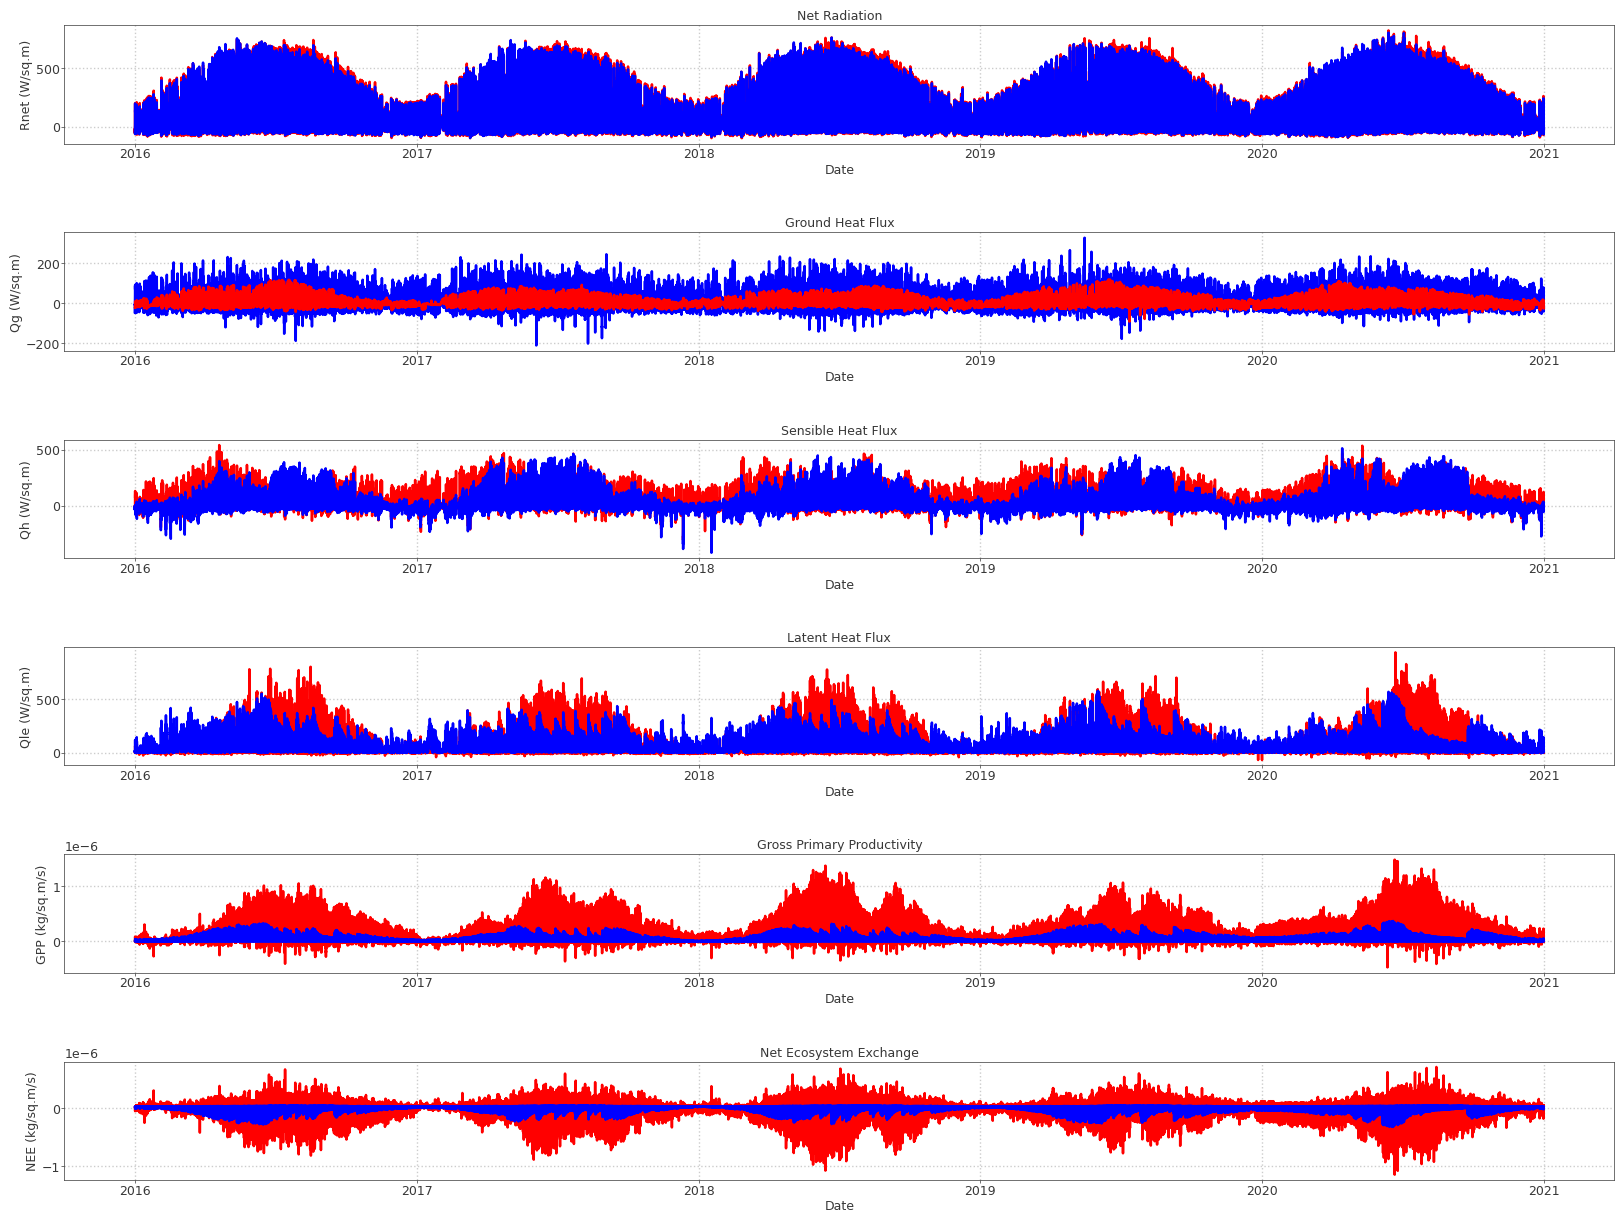

In [107]:
# Create subplots
fig, axes = plt.subplots(num_rows_line, num_cols_line, figsize=(20, 2.5 * num_rows_line))

# Flatten the axes array for easier iteration
axes_flat = axes.flatten()
        
# Plot the variable
for i,var in enumerate(variables_to_plot):
    # Get the subplot for the current variable
        ax = axes_flat[i]
    
        if var == "Qg":
                ax.plot(model_output_nc.time.values.flatten(), model_output_nc[var].values.flatten(),
                        linestyle='-',
                        linewidth=1.8,
                        color='blue',
                        label='model')
                ax.plot(insitu_data_nc.time.values.flatten(), insitu_data_nc[var].values.flatten(),
                        linestyle='-',
                        linewidth=1.8,
                        color='red',
                        label='in-situ')
        else:
                ax.plot(insitu_data_nc.time.values.flatten(), insitu_data_nc[var].values.flatten(),
                        linestyle='-',
                        linewidth=1.8,
                        color='red',
                        label='in-situ')
                ax.plot(model_output_nc.time.values.flatten(), model_output_nc[var].values.flatten(),
                        linestyle='-',
                        linewidth=1.8,
                        color='blue',
                        label='model')
        # Set the title, xlabel, ylabel, and grid
        ax.set_title(f"{variable_info[var]['title']}")
        ax.set_xlabel("Date")
        # Set the ylabel concatenating title and unit
        ax.set_ylabel(f"{var} ({variable_info[var]['unit']})")
        ax.grid(linestyle='dotted')
                
    # Adjust the space between subplots
        plt.subplots_adjust(hspace=0.75) 
plt.savefig(os.path.join("/home/khanalp/code/PhD/preprocessICOSdata/output/junks/","timeseries.png"), dpi = 300)
# Show the plot
plt.show()

In [72]:
# Calculate the number of rows and columns for subplots
num_plots_scatter = len(variables_to_plot)
num_cols_scatter = 2
num_rows_scatter = num_plots_scatter // num_cols_scatter


In [86]:
_new_black = '#373737'
sns.set_theme(style='ticks', font_scale=0.75, rc={
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans'],
    'svg.fonttype': 'none',
    'text.usetex': False,
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.size': 9,
    'axes.labelsize': 9,
    'axes.titlesize': 9,
    'axes.labelpad': 2,
    'axes.linewidth': 0.5,
    'axes.titlepad': 4,
    'lines.linewidth': 0.5,
    'legend.fontsize': 9,
    'legend.title_fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'xtick.major.size': 2,
    'xtick.major.pad': 1,
    'xtick.major.width': 0.5,
    'ytick.major.size': 2,
    'ytick.major.pad': 1,
    'ytick.major.width': 0.5,
    'xtick.minor.size': 2,
    'xtick.minor.pad': 1,
    'xtick.minor.width': 0.5,
    'ytick.minor.size': 2,
    'ytick.minor.pad': 1,
    'ytick.minor.width': 0.5,

    # Avoid black unless necessary
    'text.color': _new_black,
    'patch.edgecolor': _new_black,
    'patch.force_edgecolor': False, # Seaborn turns on edgecolors for histograms by default and I don't like it
    'hatch.color': _new_black,
    'axes.edgecolor': _new_black,
    # 'axes.titlecolor': _new_black # should fallback to text.color
    'axes.labelcolor': _new_black,
    'xtick.color': _new_black,
    'ytick.color': _new_black

    # Default colormap - personal preference
    # 'image.cmap': 'inferno'
})

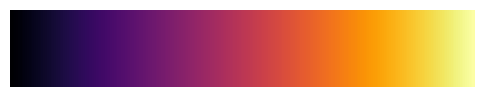

In [89]:
cmap = mpl.cm.inferno

fig, ax = plt.subplots(figsize=(6, 1))
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
ax.imshow(gradient, aspect='auto', cmap=cmap)
ax.set_axis_off()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


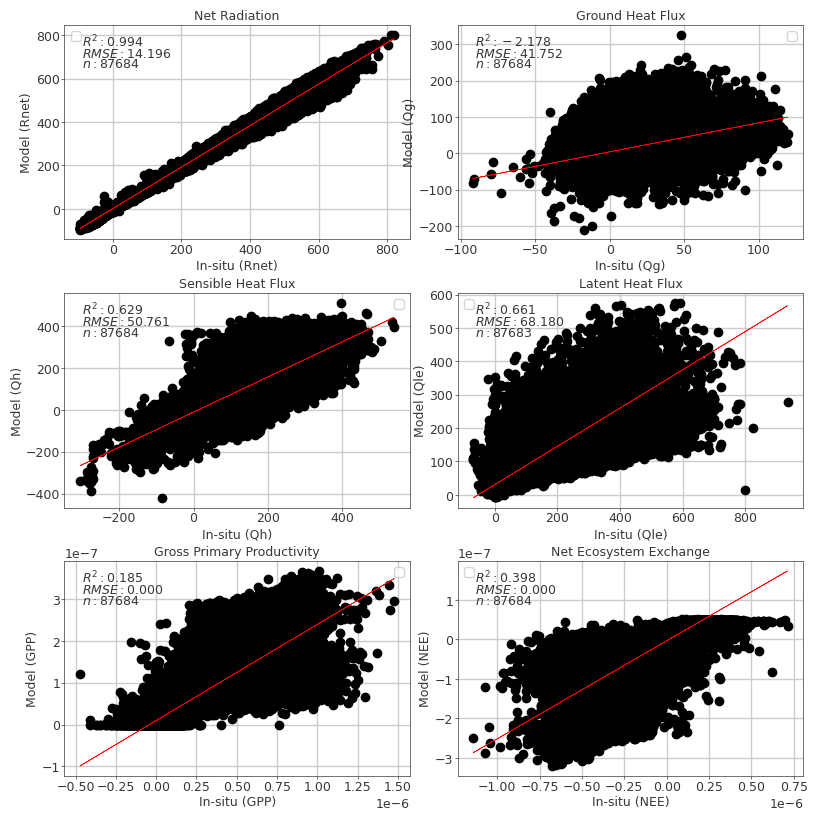

In [108]:
# Define the width ratios for the subplots
width_ratios = [5] * num_cols_scatter  # Adjust as needed

# Create subplots with adjusted width ratios
fig, axes = plt.subplots(num_rows_scatter, num_cols_scatter, figsize=(8, 8), gridspec_kw={'width_ratios': width_ratios})
fig.tight_layout()
# Iterate over variables and plot them
row_index = 0
col_index = 0
for i, var in enumerate(variables_to_plot):
    
    ax = axes[row_index][col_index]
    
    # Flattening the data variables into 1D arrays
    insitu_values = insitu_data_nc[var].values.flatten()
    model_values = model_output_nc[var].values.flatten()

    # Finding common non-missing values
    valid_indices = ~np.isnan(insitu_values) & ~np.isnan(model_values)
    
    insitu_valid = insitu_values[valid_indices]
    model_valid = model_values[valid_indices]
    
    # Computing R^2
    r2 = r2_score(insitu_valid, model_valid)

    # Computing RMSE
    rmse = np.sqrt(mean_squared_error(insitu_valid, model_valid))

    # Computing the number of observations
    n = len(insitu_valid)
    
    #kernel = gaussian_kde(np.vstack([insitu_valid, model_valid]))
    #c = kernel(np.vstack([insitu_valid, model_valid]))

                
    # Scatter plot with regression line
    ax.scatter(insitu_valid, model_valid, color='black',label='')
    m, b = np.polyfit(insitu_valid, model_valid, 1)
    ax.plot(insitu_valid, m*insitu_valid+ b, color='red', label='')
    ax.set_xlabel(f'In-situ ({var})')
    ax.set_ylabel(f'Model ({var})')
    ax.set_title(f"{variable_info[var]['title']}")
    ax.legend()
    ax.grid(True)
    
    if var in ["GPP","NEE"]:
        # Displaying computed metrics
        ax.text(0.05, 0.9, f'$R^2: {r2:.3f}$', transform=ax.transAxes)
        ax.text(0.05, 0.85, f'$RMSE: {rmse:.3f}$', transform=ax.transAxes)
        ax.text(0.05, 0.8, f'$n: {n}$', transform=ax.transAxes)    
    else:        
        ax.text(0.05, 0.9, f'$R^2: {r2:.3f}$', transform=ax.transAxes)
        ax.text(0.05, 0.85, f'$RMSE: {rmse:.3f}$', transform=ax.transAxes)
        ax.text(0.05, 0.8, f'$n: {n}$', transform=ax.transAxes) 
                
    # Adjust the space between subplots
    if col_index == (num_cols_scatter - 1):
        col_index = 0
        row_index += 1
    else:
        col_index += 1
    
# Adjust the space between subplots
plt.subplots_adjust(hspace=0.25) 
plt.savefig(os.path.join("/home/khanalp/code/PhD/preprocessICOSdata/output/junks/","scatterplot.png"), dpi = 300)
plt.show()
